In [140]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import math


**Задание 7**
1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $ A = \{x_1, x_2 : x_1^2 + x_2^2 \leq 1\} $, где
$$
f(x_1, x_2) = x_1^3 \sin \frac{1}{x_1} + 10x_1x_2^4 \cos \frac{1}{x_2}, \quad x_1, x_2 \neq 0
$$
При $x_1 = 0$ или $x_2 = 0$ функция доопределяется по непрерывности.

2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$
g(x) = (x_1 - 1)^2 + 100(x_2 - x_1^2)^2
$$

3. Оценить точность и сравнить результаты со стандартными методами оптимизации.


Part 1.

Будем генерировать 2 случайные величины $r \sim \mathcal{U}(0,1)$ и $\varphi \sim \mathcal{U}(0, 2\pi).$ Тогда $x_1 = r\cos\varphi, x_2 = r\sin\varphi.$ Однако при таком выборе распределения $r$ точки будут сосредоточены в центре круга. Поэтому хотим получить, что на каждом кольце было одинаковое количество точек, не зависящее от радиуса. Длина окружности линейно зависит от радиуса $\implies$ плотность распределения радиуса должна быть линейной. тогда $f(r) = kr\mathbb{I}(r\leq 1).$ Найдем константу из условия нормировки плотности:

$$\int\limits_0^1 krdr = k/2 = 1 \implies k = 2.$$

Функция распределения тогда равна $F(r) = r^2\mathbb{I}(r\leq 1) + \mathbb{I}(r > 1).$ Такая функция строго монотонна на отрезке $[0,1]$ и непрерывна, значит $r \sim F^{-1}(U(0,1)) = \sqrt{U(0,1)},$ где $U \sim \mathcal{U}(0,1)$. Таким образом, генерируем $r \sim \sqrt{\mathcal{U}(0,1)}, \varphi \sim \mathcal{U}(0, 2\pi).$

In [81]:
def f(x):
    return x[0] ** 3 * np.sin(1 / x[0]) + 10 * x[0] * x[1] ** 4 * np.cos(1 / x[1])

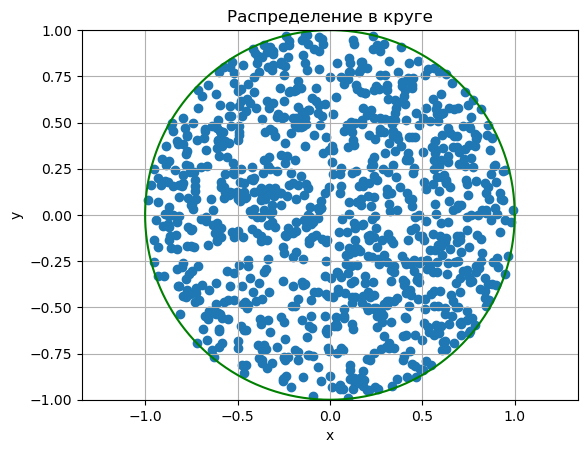

In [83]:
n = 1000
r = np.sqrt(np.random.uniform(0, 1, n))
phi = np.random.uniform(0, 2*np.pi, n)
theta = np.linspace(0, 2 * np.pi, n)
x = [r * np.cos(phi), r * np.sin(phi)]
plt.figure()
plt.title('Распределение в круге')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(np.cos(theta), np.sin(theta), color='g')
plt.scatter(x[0], x[1])
plt.grid()
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [85]:
f_x = f(x)
ans = np.min(f_x)
idx = f_x == ans
print(f'Min value = {ans}')
print(f'Point = ({x[0][idx][0]}, {x[1][idx][0]})')
print(f([x[0][idx][0], x[1][idx][0]]))

Min value = -1.1629202559916427
Point = (-0.4185848638964709, 0.8993598838245854)
-1.1629202559916427


In [87]:
from scipy.optimize import NonlinearConstraint
def f_1(x):
    if x[0] == 0:
        return 0
    if x[1] == 1:
        return x[0] ** 3 * np.sin(1 / x[0])
    return f(x)
def cons_f(x):
    if x[0] ** 2 + x[1] ** 2 <= 1:
        return f_1(x)
    else:
        return np.inf
nonlin_cons = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0, 1)
res = scipy.optimize.minimize(cons_f, [-0.5, 0.5], constraints=nonlin_cons)
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2884805581553458
       x: [-3.573e-01  9.340e-01]
     nit: 93
     jac: [ 3.184e+00 -8.319e+00]
    nfev: 364
    njev: 91


Part 2.

Метод имитации отжига.

Функция выбора соседа: нормальная случайная величина со средним $(x_i, y_i)$ и дисперсией $\sigma^2 T_i;$

Функция вероятности перехода: $\mathbb{P}(\Delta F_i) = \dfrac{1}{2}e^{-\Delta F_i / T_i};$

Функция понижения температуры: $T_{i+1} = kT_i, k \in (0, 1).$

Также нужно задать начальное состояние $(x_0, y_0)$ и начальную температуру $T.$

Алгоритм:
1. Генерируется новый кандидат $(x_{i+1}, y_{i+1}) \sim (\mathcal{N}((x_i,),\sigma^2T_i), \mathcal{N}((y_i,),\sigma^2T_i))$ и вычисляется приращение минимизируемой функции $\Delta F_i = F(x_{i+1},y_{i+1}) - F(x_{i},y_{i});$
2. Если $\Delta F_i \leq 0,$ то новое состояние равно новому кандидату, иначе переход выполняется с вероятностью $\mathbb{P}(\Delta F_i);$
3. Новая температура вычисляется по формуле выше. Если $T_{i+1} \leq \varepsilon,$ то алгоритм останавливается, иначе переход к шагу 1.

In [89]:
def neighbour_gen(x, y, t, sigma):
    x_new = np.random.randn() * sigma * np.sqrt(t) + x
    y_new = np.random.randn() * sigma * np.sqrt(t) + y
    return x_new, y_new

In [91]:
def transform_prob(df, t):
    return 1/2*np.exp(-df / t)

In [93]:
def temp_update(t, k):
    return k * t

In [95]:
def rosenbrock_func(x, y):
    return (x - 1) ** 2 + 100 * (y - x ** 2) ** 2

In [97]:
def simulated_annealing(f, x_0, y_0, sigma, k, t_0, eps):
    x_cur = x_0
    y_cur = y_0
    t_cur = t_0
    f_cur = f(x_cur, y_cur)
    while t_cur > eps:
        x_new, y_new = neighbour_gen(x_cur, y_cur, t_cur, sigma)
        f_new = f(x_new, y_new)
        df = f_new - f_cur
        if df <= 0:
            x_cur, y_cur = x_new, y_new
            f_cur = f_new
        else:
            if np.random.uniform() <= transform_prob(df, t_cur):
                x_cur, y_cur = x_new, y_new
                f_cur = f_new
        t_cur = temp_update(t_cur, k)
    return f_cur, x_cur, y_cur

In [99]:
x_0 = 0
y_0 = 0
sigma = 4
k = 0.9
t_0 = 2
eps = 10 ** (-5)
simulated_annealing(rosenbrock_func, x_0, y_0, sigma, k, t_0, eps)

(0.005629151596840199, 0.9249762907551835, 0.8556582518814888)

Известно, что функция Розенброка имеет минимум в точке $(1, 1)$ и значение функции в этой точке равно 0.
Проведем несколько итераций и посмотрим на график решений, найденных методом имитации отжига.

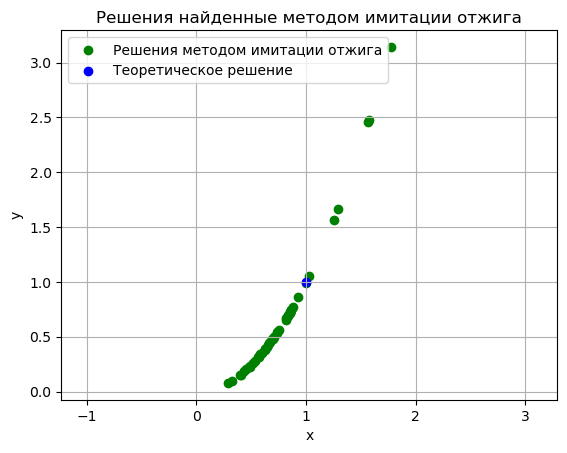

In [101]:
m = 50
x = np.zeros(m)
y = np.zeros(m)
for i in range(m):
    _, x[i], y[i] = simulated_annealing(rosenbrock_func, x[i], y[i], sigma, k, t_0, eps)
plt.figure()
plt.scatter(x, y, color='g', label='Решения методом имитации отжига')
plt.scatter(1,1, color='b', label='Теоретическое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.axis('equal')
plt.legend()
plt.title('Решения найденные методом имитации отжига')
plt.show()

Оценим точность метода случайного поиска. Из формулы Лагранжа получаем следующую оценку:
$$
|f(x_1,x_2) - f(x_1^*, x_2^*)| \leq \sup\limits_{(x_1', x_2') \in A}\left\{\sqrt{\left(\dfrac{\partial f(x_1', x_2')}{\partial x_1}\right)^2+ \left(\dfrac{\partial f(x_1',x_2')}{\partial x_2}\right)^2}\right\}||(x_1 - x_1^*, x_1 - x_2^*)||.
$$

$$
f(x_1, x_2) = x_1^3 \sin \frac{1}{x_1} + 10x_1x_2^4 \cos \frac{1}{x_2}, \quad x_1, x_2 \neq 0
$$

Посчитаем частные производные:
$$
\dfrac{\partial f}{\partial x_1} = 3x_1^2\sin\dfrac{1}{x_1} - x_1 \cos\dfrac{1}{x_1} + 10 x_2^4\cos\frac{1}{x_2}
$$
$$
\dfrac{\partial f}{\partial x_2} = 40 x_1 x_2^3\cos\frac{1}{x_2} + 10 x_1x_2^2\sin\frac{1}{x_2}
$$
Тогда
$$
|f(x_1, x_2) - f(x_1^*, x_2^*)| \leq \sqrt{14^2 + 50^2}||(x_1 - x_1^*, x_1 - x_2^*)||.
$$

Пусть $(x_1^*,x_2^*)$ ~--~ теоретически полученная точка минимума, $||(x_1 - x_1^*, x_1 - x_2^*)|| = \delta$.
Получаем точность $\varepsilon \leq \sqrt{2696}\delta.$ Введем дополнительные параметры: пусть $p$ ~---~ вероятность попадания хотя бы одной точки в $\delta$-окрестность точки минимума. Тогда $p = 1 - \mathbb{P}(\forall i: ||x_i - x^*|| > \delta) = 1 - \left(\mathbb{P}(||x_i - x^*|| > \delta)\right)^n = 1 - \left(1 - \mathbb{P}(||x_i - x^*|| \leq \delta)\right)^n,$ а вероятность того, что конкретная точка попала в $\delta$-окрестность не меньше $\delta^2.$ Таким образом, $p \geq 1 - (1 - \delta)^n.$ Тогда $\varepsilon \leq \sqrt{2696}\left(1-(1-p)^{1/n}\right).$


In [105]:
x0 = np.array([0, 0]) #Метод сопряжённых градиентов
res = scipy.optimize.minimize(scipy.optimize.rosen, x0, method='CG', tol=1e-8)
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.0056121165089653e-11
       x: [ 1.000e+00  1.000e+00]
     nit: 22
     jac: [-6.518e-09  3.236e-09]
    nfev: 171
    njev: 57


**Задание 8**

Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге:
$$
\begin{cases}
    \Delta u = 0, \quad (x,y) \in D = \{x, y: x^2+y^2 \leq 1\}, \\
    u|_{\partial D} = f(x, y), \\
    u\in C^2(D), \quad f\in C(\partial D), \\
\end{cases}
$$
Для функции $f(x, y) = x^2-y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

Рассмотрим квадратную сетку $x_i = -1 + i * h, y_j = -1 + j * h, h = 1 / n, n$ ~--~ количество точек разбиения отрезка $[-1,1].$ Естественным образом определяются понятия соседних точек. Далее разделим все узлы сетки, принадлежащие кругу $D$ на две группы: внутренние(все 4 соседа этой вершины лежат в круге $D$) и граничные(есть сосед вне круга $D$.) В граничных узлах $u$ равна значению функции $f$ в этом узле, а во внутренних в соответствии с разностной схемой:
$$
u_{ij} = \dfrac{1}{4}\left(u_{i,j-1}+ u_{i,j+1} + u_{i-1,j} + u_{i+1,j}\right).
$$

Будем рассматривать задачу блуждания частицы по этой сетке. Пусть частица начинает блуждание в узле $(x_i,y_j)$ Вероятности переходов в соседние узлы равны $\dfrac{1}{4}.$  Будем считать, что частица, попавшая на граничный узел останавливается в нем. Тогда возникает задача нахождения вероятности того, что частица, начав путь по сетке из вершины $(x_i, y_j),$ закончит его в граничной точке $(x^*,y^*).$ Обозначим ее через $p_{ij}^*$ Считаем, что частица обязательно попадет на границу. Воспользуемся формулой полной вероятности:

$$
p_{ij}^* = \dfrac{1}{4}\left(p_{i,j-1}^*+ p_{i,j+1}^* + p_{i-1,j}^* + p_{i+1,j}^*\right).
$$
Дополнительно заметим, что $p_*^* = 1, p^*_+ = 0$, где $(x^+,y^+)$ ~--~ граничная точка.

Пусть частица при попадании на границу переносит температуру $f(x^*,y^*).$ Значение температуры, перенесенной из узла $(x_i, y_j)$ является случайной величиной $\xi_{ij},$ вероятность переноса температуры $f(x^*,y^*)$ равна $p_{ij}^*.$ Тогда верно следующее равенство:
$$
\mathbb{E}\xi_{ij} = \sum\limits_{(x^*,y*)} f(x^*, y^*)p_{ij}^*.
$$
Обозначим эту функцию через $g(i, j).$ Для нее справедливо такое же тождество, как и для $p_{ij}^*:$
$$
g(i,j) = \dfrac{1}{4}(g(i-1, j) + g(i+1,j) + g(i,j-1) + g(i, j+1)).
$$

На границе для функции $g$ верно следующее: $g(*,*) = f(x^*,y^*).$

Тогда функция $g(i,j)$ является решением исходной задачи Дирихле.

In [107]:
def is_inside_circle(x, y):
    return x ** 2 + y ** 2 <= 1

In [109]:
def count_neighbours(grid):
    n_rows, n_cols = grid.shape
    neighbours = np.zeros(grid.shape)
    for i in range(1, n_rows - 1):
        for j in range(1, n_cols - 1):
            if np.isnan(grid[i, j]):
                continue
            n = 0
            for dx in [-1, 1]:
                for dy in [-1, 1]:
                    if is_inside_circle(-1 + (i + dx) * h, -1 + (j + dy) * h) and not np.isnan(grid[i + dx, j + dy]):
                        n += 1
            neighbours[i, j] = n
    return neighbours

In [111]:
#разбиение множества точек на внутренние и граничные
def segmentation(h):
    x = np.arange(-1 - 2 * h, 1 + 2 * h, h)
    y = np.arange(-1 - 2 * h, 1 + 2 * h, h)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    mask = (X**2 + Y ** 2) > 1
    Z[mask] = np.nan #вне окружности Nan
    neighbours_count = count_neighbours(Z)

    mask_internal = (neighbours_count == 4)
    mask_boundary = (neighbours_count > 0)& ~mask_internal
    internal_points = np.column_stack((X[mask_internal], Y[mask_internal]))
    boundary_points = np.column_stack((X[mask_boundary], Y[mask_boundary]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(internal_points[:, 0], internal_points[:, 1])
    ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='blue')
    plt.title('Точки на двумерной сетке')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()
    return internal_points, boundary_points, X, Y

In [113]:
def random_walk(x, y, boundary_points, h):
    while [x, y] not in boundary_points:
        direction = np.random.choice(['u', 'd', 'l', 'r'])
        if direction == 'up':
            y += h
        elif direction == 'down':
            y -= h
        elif direction == 'left':
            x -= h
        elif direction == 'right':
            x += h
    return x, y

In [115]:
def monte_carlo_simulation(h, num_walks, f):
    internal_points, boundary_points, X, Y = segmentation(h)
    res = np.zeros(X.shape)
    num_of_match = np.zeros(X.shape)
    for i in range(num_walks):
        idx = np.random.randint(internal_points.shape[0])
        [x_start, y_start] = internal_points[idx]
        x_bound, y_bound = random_walk(x_start, y_start, boundary_points, h)
        val  = f(x_bound, y_bound)
        idx1 = np.where((X == x_start) & (Y == y_start) )
        res[idx1[0], idx1[1]] += val
        num_of_match[idx1[0], idx1[1]] += 1
    num_of_match[num_of_match == 0] = 1
    res /= num_of_match
    return X, Y, res

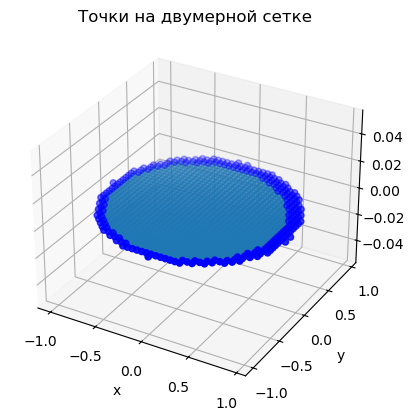

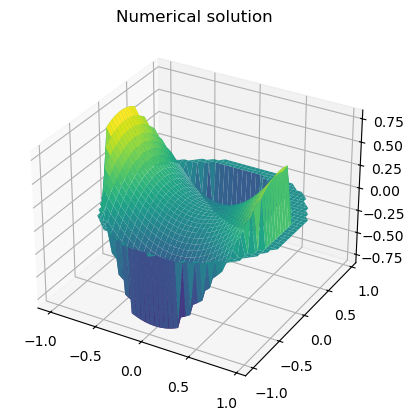

In [117]:
h = 0.05
num_walks = 10 ** 4
f = lambda x, y: x ** 2 - y ** 2
X, Y, res = monte_carlo_simulation(h, num_walks, f)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
res[res == np.nan] = 0
X_new = np.where(is_inside_circle(X, Y), X, np.nan)
Y_new = np.where(is_inside_circle(X, Y), Y, np.nan)
res_new = np.where(is_inside_circle(X, Y), res, np.nan)
ax.plot_surface(X_new, Y_new, res_new, cmap='viridis')
plt.title("Numerical solution")
plt.show()

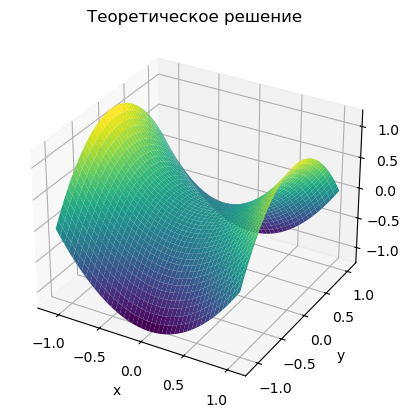

In [119]:
h = 0.05
x = np.arange(-1 - 2 * h, 1 + 2 * h, h)
y = np.arange(-1 - 2 * h, 1 + 2 * h, h)
X, Y = np.meshgrid(x, y)
Z = X ** 2 - Y ** 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.title("Теоретическое решение")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Задание 9**

Рассмотреть два вида гауссовских процессов:

- Винеровский процесс $ W(t), t \in [0; 1], W(0) = 0 $

- Процесс Орнштейна–Уленбека $ X(t), t \in [0; 1], X(0) = X_0 $, т.е. стационарный марковский гауссовский процесс. Начальные значения $ X_0 $ следует выбирать случайным образом так, чтобы полученный процесс был стационарным.

Для данных процессов:

1. Найти ковариационную функцию и переходные вероятности.
2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.
3. Построить график траектории, не соединяя точки ломаной, с целью получения визуально непрерывной линии.


Случайный процесс $W(t), t \in [0, 1]$ называют винеровским с параметром $\sigma$, если
1. $W(0) = 0$ почти наверное;
2. $W(t)$ ~--~ процесс с независимыми приращениями;
3. $W(t) - W(s) \sim \mathcal{N}(0, \sigma^2 (t - s)).$

Отсюда получаем $W(t) - W(0)\sim \mathcal{N}(0, \sigma^2 t)$ и $\mathbb{E}W(t) = 0, Var\,W(t)= \sigma^2 t.$

Если $s \leq t,$ то $W(t) = W(s) + (W(t) - W(s)).$ В силу независимости приращений получаем $R(s,t) =\mathbb{E}W(s)W(t) = \mathbb{E}W^2(s) + \mathbb{E}W(s)\mathbb{E}(W(t) - W(s)) = \mathbb{E}W^2(s) = \sigma^2 s.$
Если $t < s,$ то $W(s) = W(t) + (W(t) - W(s)).$ Аналогично получаем $R(s,t) = \mathbb{E}W^2(t) = \sigma^2 t.$
Объединяя полученные результаты, получаем $R(s,t) = \sigma^2 \min\{s,t\}.$

Пусть $t_1 < t_2< t_3$. Найдем распределение $Y = (W(t_2)|W(t_1) = x_1, W(t_3) = x_3).$
$W(t) \sim \mathcal{N}(0, \sigma^2t) \implies f_Y(x_2) = \dfrac{f_{123}(x_1,x_2,x_3)}{f_{13}(x_1,x_3)},$ где $f_{123}(x_1,x_2,x_3)$~--~ совместная плотность $(W(t_1), W(t_2), W(t_3)),$ $f_{13}(x_1,x_3)$ ~--~ совместная плотность $(W_1(t_1), W_3(t_3)).$ Известно, что плотность $n$-мерного нормального распределения с математическим ожиданием $\mu$ и ковариационной матрицей $\Sigma$ имеет вид:
$$
f(x_1,x_2,\dots, x_n) = \dfrac{1}{\sqrt{(2\pi)^n |\Sigma|}}exp(-\dfrac{1}{2}(x - \mu)^T)\Sigma^{-1}(x-\mu).
$$

Используя полученную формулу для ковариационной матрицы, получим:
$$
\Sigma_{13} = \sigma^2\begin{pmatrix}
t_1 & t_1\\
t_1 & t_3
\end{pmatrix}, \quad
\Sigma_{123} = \sigma^2\begin{pmatrix}
t_1 & t_1 & t_1\\
t_1 & t_2 & t_2\\
t_1 & t_2 & t_3
\end{pmatrix}.
\
$$
Для простоты формулы предположим, что $t_2 = \dfrac{t_1 + t_3}{2}.$

In [12]:
import sympy as sp

In [594]:
x1 = sp.Symbol('x1', real=True)
x2 = sp.Symbol('x2', real=True)
x3 = sp.Symbol('x3', real=True)
t1 = sp.Symbol('t1', real=True)
t3 = sp.Symbol('t3', real=True)
t2 = (t1 + t3) / 2
sigma = sp.Symbol('sigma', real=True)
S1 = sigma ** 2 * sp.Matrix([[t1, t1, t1],
                             [t1, t2, t2],
                             [t1, t2, t3]

])
S2 = sigma ** 2 * sp.Matrix([[t1, t1],
                             [t1, t3]
])
x123 = sp.Matrix([x1, x2, x3])
x13 = sp.Matrix([x1, x3])
var = (S1.det() / S2.det()).simplify()
exp1 = - 1 / 2 * (x123.T @ S1.inv() @ x123)[0]
exp2 = - 1 / 2 * (x13.T @ S2.inv() @ x13)[0]
exp_deg = (exp1 - exp2).simplify()
sp.print_latex(var)
sp.print_latex(exp_deg)

\frac{\sigma^{2} \left(- t_{1} + t_{3}\right)}{4}
\frac{1.0 \cdot \left(0.5 x_{1}^{2} - 2.0 x_{1} x_{2} + 1.0 x_{1} x_{3} + 2.0 x_{2}^{2} - 2.0 x_{2} x_{3} + 0.5 x_{3}^{2}\right)}{\sigma^{2} \left(t_{1} - t_{3}\right)}


Получили дисперсию $S = \dfrac{\sigma^{2} \left(- t_{1} + t_{3}\right)}{4}$ и степень экспоненты 
$
\dfrac{0.5 x_1^2-2 x_1 x_2 + x_1 x_3 + 2 x_2^2 -2 x_2 x_3 + 0.5 x_3^2}{\sigma^2(t_1 - t_3)} = -
\dfrac{x_1^2-4 x_1 x_2 + 2x_1 x_3 + 4 x_2^2 -4 x_2 x_3 + x_3^2}{2\sigma^2(t_3 - t_1)} = - 
\dfrac{(2x_2 - (x_1 + x_3)^2)}{2\sigma^2(t_3 - t_1)} = -\dfrac{(x_2 - \frac{x_1 + x_3}{2})^2}{2 \frac{\sigma^2(t_3 - t_1)}{4}}. 
$
Таким образом $Y \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{2}, \dfrac{\sigma^{2} \left(- t_{1} + t_{3}\right)}{4}\right).$


Для моделирования воспользуемся методом добавления разбиения отрезка. Знаем, что $W(1) = W(1) - W(0) \sim \mathcal{N}(0, sigma^2), W(0) = 0.$
Зная значения $W(t_1)$ и $W(t_3),$ найдем $W(t_2) = W(\dfrac{t_1 + t_3}{2}) \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{2}, \dfrac{\sigma^2(t_3 - t_1)}{4}\right).$ Будем дробить отрезок до тех пор, пока не наберем точек не меньше требуемого количества, при этом если проходиться по всем парам соседних посчитанных значений $W(t_1)$ и $W(t_3),$ то получим $2^n+1$ точку, где $n$ ~--~ номер итерации прохода по всем значениям.

In [125]:
def wiener_process(sigma, n):
    proc = np.zeros(2 ** n + 1)
    proc[-1] = np.random.randn() * sigma
    for i in range(n):
        for j in range(0, 2 ** n + 1 - 2 ** (n - i), 2 ** (n - i)):
            x1 = proc[j]
            x3 = proc[j + 2 ** (n - i)]
            idx = j + 2 ** (n - i) // 2
            proc[idx] = np.random.randn() * (sigma / 2 * np.sqrt(2 ** (-i))) + (x1 + x3) / 2
    return proc

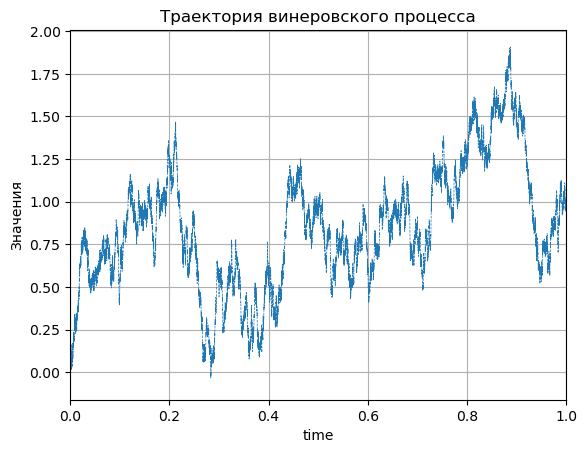

In [145]:
sigma = 2
n = 15
proc = wiener_process(sigma, n)
grid = np.linspace(0, 1, 2 ** n + 1)
plt.figure()
plt.xlabel('time')
plt.xlim(0, 1)
plt.plot(grid, proc, '--', linewidth=0.5)
plt.title('Траектория винеровского процесса')
plt.ylabel('Значения')
plt.grid()
plt.show()

Процесс Орнштейна-Уленбека.

Этот процесс вводится как единственный нетривиальный гауссовский процесс, являющийся стационарным и обладающий марковским свойством.
Из стационарности следует, что $\mathbb{E}X_t = a, var(X_t) = \sigma^2, K_X(s,t) = \rho(|s-t|).$
Из марковского свойства следует, что $K_X(s,t) = K_X(s,\tau)K_X(\tau,t), \forall 1 \leq s \leq \tau \leq t \leq n.$
$\rho(|s-t|) = \rho(|s-\tau|)\rho(|\tau - t|) \Leftrightarrow \rho(x + y) = \rho(x)\rho(y).$
Получили уравнение Коши, которое имеет тривиальное решение и решение $K_X(t) = e^{-\lambda t}, \lambda > 0.$
В силу гауссовости получаем, что все $X_t$ независимы в совокупности, поэтому тривиальное решение не рассматриваем.
Тогда $R(s,t) = \sigma^2e^{-\lambda|s-t|}, \lambda > 0.$ 

Значение $X(0) = X_0$ неизвестно, поэтому будем генерировать из нормального распределения с нулевым средним и дисперсией $\sigma^2.$
Найдем распределение $Y = (X(1)| X(0) = x_0).$

Ковариационная матрица равна $R_0 = \sigma^2\begin{pmatrix} 
1 & e^{-\lambda}\\
e^{-\lambda} & 1
\end{pmatrix}.$ Тогда
$$
f_Y(x_1) = \dfrac{f_{X_{0}X_{1}}(x_0,x_1)}{f_{X_{0}}(x_0)}
$$
$$f_{X_{0}X_{1}}(x_0, x_1) = \frac{1}{\sqrt{4\pi^2 det(R_0)}}exp\{-\frac{1}{2}x R_0^{-1}x^{T}\}$$ 
$$f_{X_{0}}(x_0) = \frac{1}{\sqrt{2\pi \sigma^2}}exp\{-\frac{x_0^2}{2\sigma^2}\}.$$



$$
R_0^{-1} = \dfrac{1}{\sigma^2 (1-e^{-2\lambda})} \begin{pmatrix}
1 & -e^{-\lambda}\\
-e^{-\lambda} & 1
\end{pmatrix}
$$
$$
xR_0^{-1}x^T =\dfrac{1}{\sigma^2 (1-e^{-2\lambda})} \begin{pmatrix}
x_0 & x_1
\end{pmatrix}
\begin{pmatrix}
1 & -e^{-\lambda}\\
-e^{-\lambda} & 1
\end{pmatrix}
\begin{pmatrix}
x_0\\ 
x_1
\end{pmatrix}
= \dfrac{1}{\sigma^2 (1-e^{-2\lambda})}(x_0^2 - 2 x_0 x_1 e^{-\lambda} + x_1^2) 
$$


$$
-\dfrac{1}{2\sigma^2}\left(\dfrac{1}{1-e^{-2\lambda}}(x_0^2 - 2 x_0 x_1 e^{-\lambda} + x_1^2) - x_0^2\right) = -\dfrac{1}{2\sigma^2(1 - e^{-2\lambda})}(x_1^2 - 2 x_0 x_1 e^{-\lambda} + x_0^2e^{-2\lambda}) = -\dfrac{(x_1 - x_0e^{-\lambda})^2}{2\sigma^2(1 - e^{-2\lambda})}
$$

Получаем
$$
\sigma^* = \sigma\sqrt{1-e^{-2\lambda}}, \quad \mu^* = x_0e^{-\lambda}.
$$

Таким образом, $(X(1)|X(0) = x_0) \sim \mathcal{N}(x_0e^{-\lambda}, \sigma^2(1-e^{-2\lambda})).$

Далее хотим смоделировать процесс методом разбиения отрезка. Найдем распределение $Y = (X(t_2) | X(t_1) = x_1, X(t_3) = x_3), \quad t_1 < t_3, t_2 = \dfrac{t_1 + t_3}{2}.$
$$
f_{X_{t_2}}(x_2) = \dfrac{f_{123}(x_1,x_2,x_3)}{f_{13}(x_1,x_3)}.
$$
$$
\Sigma_{123} = \sigma^2 \begin{pmatrix}
1 & e^{-\lambda(t_2 - t_1)} & e^{-\lambda(t_3 - t_1)}\\
e^{-\lambda(t_2 - t_1)} & 1 & e^{-\lambda(t_3 - t_2)}\\
e^{-\lambda(t_3 - t_1)} & e^{-\lambda(t_3 - t_2)} & 1\\
\end{pmatrix}
$$
$$
\Sigma_{13} = \sigma^2 \begin{pmatrix}
1 & e^{-\lambda(t_2 - t_1)}\\
e^{-\lambda(t_2 - t_1)} & 1
\end{pmatrix}
$$


In [581]:
x1 = sp.Symbol('x1', real=True)
x2 = sp.Symbol('x2', real=True)
x3 = sp.Symbol('x3', real=True)
t1 = sp.Symbol('t1', real=True)
t3 = sp.Symbol('t3', real=True)
t2 = (t1 + t3) / 2
sigma = sp.Symbol('sigma', real=True)
d = sp.Symbol('d', real=True)
S1 = sigma ** 2 * sp.Matrix([[1, sp.exp(-lam * d), sp.exp(-lam * 2*d)],
                             [sp.exp(-lam * d), 1, sp.exp(-lam * d)],
                             [sp.exp(-lam * 2*d), sp.exp(-lam * d), 1]

])
S2 = sigma ** 2 * sp.Matrix([[1, sp.exp(-lam * 2 * d)],
                             [sp.exp(-lam *2 * d), 1]
])
x123 = sp.Matrix([x1, x2, x3])
x13 = sp.Matrix([x1, x3])
var = (S1.det() / S2.det()).simplify()
exp1 = - 1 / 2 * (x123.T @ S1.inv() @ x123)[0]
exp2 = - 1 / 2 * (x13.T @ S2.inv() @ x13)[0]
exp_deg = (exp1 - exp2).simplify()
display(var)
display(exp_deg)

sigma**2*tanh(d*lam)

-(0.5*x1**2*exp(2*d*lam) - 1.0*x1*x2*exp(3*d*lam) - 1.0*x1*x2*exp(d*lam) + 1.0*x1*x3*exp(2*d*lam) + 0.5*x2**2*exp(4*d*lam) + 1.0*x2**2*exp(2*d*lam) + 0.5*x2**2 - 1.0*x2*x3*exp(3*d*lam) - 1.0*x2*x3*exp(d*lam) + 0.5*x3**2*exp(2*d*lam))/(sigma**2*(exp(4*d*lam) - 1))

Получили $\sigma^* = \sigma\sqrt{\tanh(d \lambda)} = \sigma \sqrt{\dfrac{e^{2d\lambda} - 1}{e^{2d\lambda} + 1}}.$
Раскрывая скобки и приводя подобные в степени экспоненты, получим $\mu^* = \dfrac{e^{\lambda d}(x_1 + x_3)}{e^{2\lambda d} + 1}.$

Таким образом $(X(t_2)|X(t_1) = x_1, X(t_3) = x_3) \sim \mathcal{N}\left(\dfrac{e^{\lambda d}(x_1 + x_3)}{e^{2\lambda d} + 1}, \sigma^2 \dfrac{e^{2d\lambda} - 1}{e^{2d\lambda} + 1}\right)$

In [136]:
def ornstein_uhlenbeck_simulation(sigma, n, L):
    proc = np.zeros(2 ** n + 1)
    proc[0] = np.random.randn() * sigma
    proc[2 ** n] = proc[0] * math.exp(-L) + np.random.randn() * sigma * math.sqrt(1 - math.exp(- 2 * L))
    for i in range(n):
        idx_step = 2 ** (n - i)
        dt = 2 ** (- i)
        for j in range(0, 2 ** n + 1 - idx_step, idx_step):
            x1 = proc[j]
            x2 = proc[j + idx_step]
            d = dt
            exp_tmp = math.exp(2 * d * L)
            proc[j + idx_step // 2] = sigma * math.sqrt((exp_tmp - 1) / (exp_tmp + 1)) * np.random.randn() + math.exp(L * d) * (x1 + x2) / (exp_tmp + 1)
    return proc

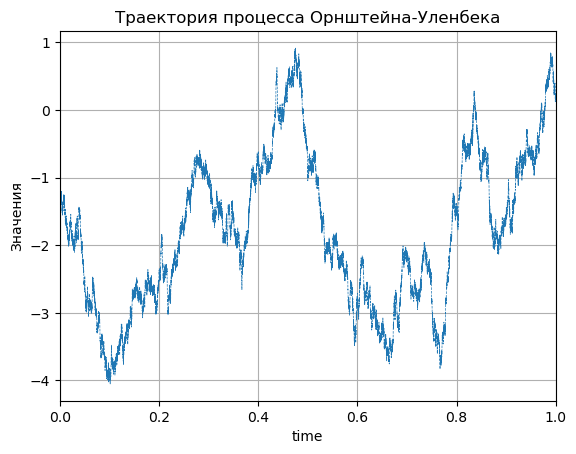

In [150]:
sigma = 2
n = 15
L = 1
proc = ornstein_uhlenbeck_simulation(sigma, n, L)
grid = np.linspace(0, 1, 2 ** n + 1)
plt.figure()
plt.xlabel('time')
plt.xlim(0, 1)
plt.plot(grid, proc, '--', linewidth=0.5)
plt.title('Траектория процесса Орнштейна-Уленбека')
plt.ylabel('Значения')
plt.grid()
plt.show()

**Задание 10**

Произвести фильтрацию одномерного процесса Орнштейна–Уленбека:

1. Используя генератор белого шума, добавить к реализации процесса Орнштейна–Уленбека случайную ошибку с заранее известной дисперсией.
2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, считая известными параметры шума и процесса.
3. Рассмотреть следующие виды шума:
   1. Гауссов
   2. Коши (шум имеет распределение Коши)


Рассматриваем процесс Орнштейна-Уленбека на сетке, тогда его "координаты" изменяются по следующему закону:
$$x_{k+1} = ax_k + v_k$$
Динамика зашумленного сигнала:
$$y_k = x_k + \xi_k$$
По условию знаем дисперсию ошибки: $\xi_k \sim N(0, r^2). \\$
Будем считать, что $v_k \sim N(0, q^2)$. Из предыдущего задания знаем, что $x_0 \sim N(0, \sigma^2)$.
Для дальшейшего решения задачи необходимо найти значения параметров $a, q$. Зная, что $x_k$ и $v_k$ независимы, а также свойства процесса Орнштейна-Уленбека:
$$R(t_k, t_k) = \sigma^2,$$
$$R(t_k, t_{k+1}) = cov(x_{t_k}, x_{t_{k+1}}) = a\cdot var(x_{t_k}) = \sigma^2 e^{-\lambda(t_{k+1} - t_k)} \quad \Rightarrow \quad a = e^{-\lambda(t_{k+1} - t_k)},$$
$$R(t_{k+1}, t_{k+1}) = a^2 \sigma^2 + q^2 = \sigma^2 \quad \Rightarrow \quad q^2 = \sigma^2(1 - e^{-2\lambda(t_{k+1} - t_k)}).$$
Прогнозируемое фильтром Калмана значение $x_{k+1}^*$:
$$x_{k+1}^* = K_{k+1}y_{k+1} + (1 - K_{k+1})ax_{k}^*,$$ где $K_{k+1}$ ~--~ коэффициент Калмана.

Далее необходимо выбрать коэффициент Калмана $K_{k+1}$ таким, чтобы получившееся оптимальное значение прогноза $x_{k+1}^*$ было наиболее близко к истинному значению $x_{k+1}$. Чтобы найти точное значение коэффициента Калмана $K_{k+1}$, нужно минимизировать ошибку:
$$e_{k+1} = x_{k+1} - x_{k+1}^*$$
Тогда 
$$e_{k+1} = x_{k+1} - K_{k+1}y_{k+1} - (1 - K_{k+1})ax_{k}^* = ax_k + v_k - K_{k+1}(ax_k + v_k + \xi_{k+1}) - (1 - K_{k+1})ax_{k}^* = (1 - K_{k+1})(ae_k + v_k) - K_{k+1}\xi_{k+1}.$$
Тогда необходимо минимизировать $\mathbb{E}(e^2_{k+1}) \rightarrow min$:
$$\mathbb{E}(e^2_{k+1}) = (1 - K_{k+1})^2(a^2\mathbb{E}e_k^2 + q^2) + K_{k+1}^2r^2$$
Приравнивая производную (по $K_{k+1}$) выражения к 0, получим
$$K_{k+1} = \frac{a^2\mathbb{E}e_k^2 + q^2}{a^2\mathbb{E}e_k^2 + q^2 + r^2}$$
Подставляем это значение в минимизируемую функцию
$$\mathbb{E}(e^2_{k+1}) = \frac{r^2(a^2\mathbb{E}e_k^2 + q^2)}{a^2\mathbb{E}e_k^2 + q^2 + r^2}$$
Запишем алгоритм работы программы:

1) $\mathbb{E}(e_0^2) = r^2$, $x_0^* = y_0$.
2) На каждой итерации вычисляем $\mathbb{E}(e^2_{k+1})$ по формуле, представленной выше. Далее вычисляем $K_{k+1} = \dfrac{\mathbb{E}(e^2_{k+1})}{r^2}$. Зная коэффициент Калмана вычисляем $x_{k+1}^*$ по формуле выше.
Параметры программы: $\sigma, r, \lambda,$ число точек.


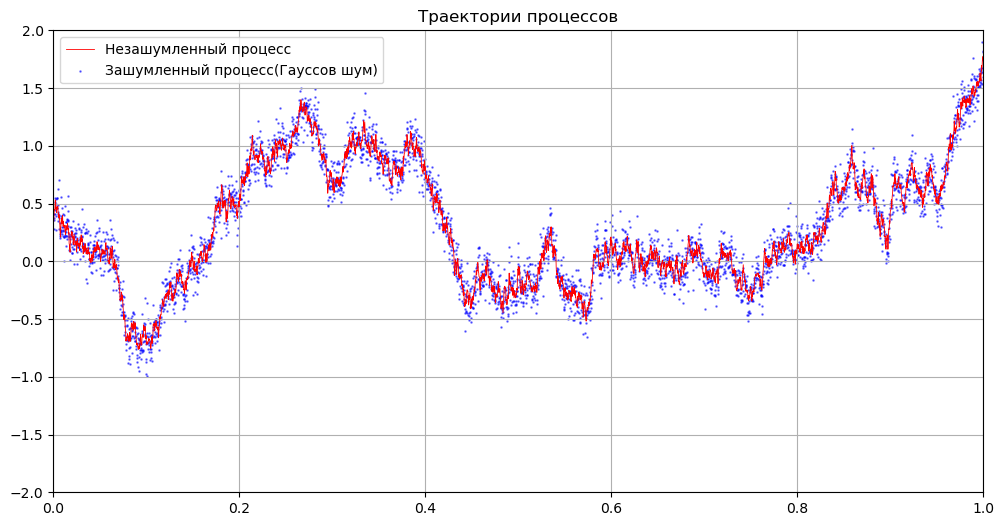

In [623]:
sigma = 1
L = 1
r = 0.1
n = 12
num_points = 2 ** n + 1
x = ornstein_uhlenbeck_simulation(sigma, n, L)
noise = np.random.randn(num_points) * r
y = x + noise
grid = np.linspace(0, 1, num_points)
plt.figure(figsize=(12, 6))
plt.plot(grid, x, color='r', linewidth=0.6, label='Незашумленный процесс')
plt.scatter(grid, y, color='b', s=0.7, alpha=0.5, label='Зашумленный процесс(Гауссов шум)')
plt.xlim(0,1)
plt.ylim(-2,2)
plt.legend()
plt.grid()
plt.title('Траектории процессов')
plt.show()


In [625]:
def kalman_filter(sigma, L, r, y):
    num_points = len(y)
    x = np.zeros_like(y)
    err = np.zeros_like(y)
    h = 1 / (num_points - 1)
    a = np.exp(-L * h)
    q = sigma ** 2 * (1 - np.exp(-L * 2 * h))
    x[0] = y[0]
    err[0] = r ** 2
    for i in range(1, num_points):
        err[i] = r ** 2 * (a ** 2 * err[i - 1] + q) / (a ** 2 * err[i - 1] + q + r ** 2)
        k = err[i] / (r ** 2)
        x[i] = k * y[i] + (1 - k) * a * x[i - 1]
    return x, err

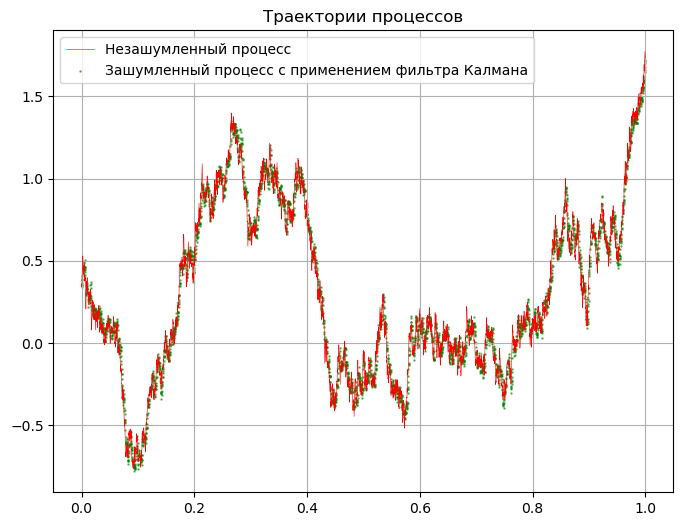

In [627]:
x_filtered, err = kalman_filter(sigma, L, r, y)
plt.figure(figsize=(8,6))
plt.plot(grid, x, color='red', linewidth=0.4, label='Незашумленный процесс')
plt.scatter(grid, x_filtered, color='green', s=0.7, alpha=0.5, label="Зашумленный процесс с применением фильтра Калмана")
plt.title("Траектории процессов")
plt.legend()
plt.grid()
plt.show()

Ошибка фильтрации имеет нормальное распределение и доверительный интервал имеет вид:
$$[x^* - \varepsilon, x^* + \varepsilon], \quad \varepsilon = -\sqrt{\mathbb{E}e}\cdot erf(\frac{\alpha}{2}),$$
где $\alpha$ - уровень значимости.

In [630]:
from scipy.stats import norm

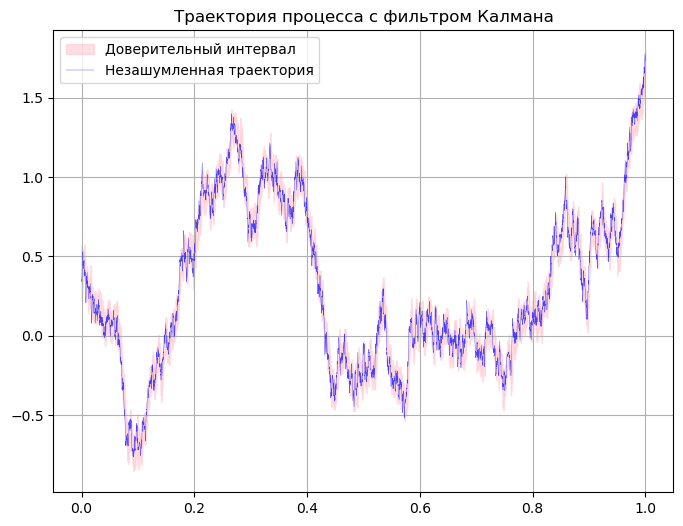

In [632]:
alpha = 0.1
eps = - np.sqrt(err) * norm.ppf(alpha / 2)
low = x_filtered - eps
upper = x_filtered + eps
plt.figure(figsize=(8,6))
plt.fill_between(grid, low, upper, color="pink", alpha=0.5, label="Доверительный интервал")
plt.plot(grid, x, color='b', lw=0.3, alpha=0.7, label="Незашумленная траектория")
plt.title("Траектория процесса с фильтром Калмана")
plt.legend()
plt.grid()
plt.show()

Для шума с распределением Коши остаются верны те же формулы.

In [635]:
def Cauchy_gen(x_0, gamma, sizes):
    return gamma * np.tan(np.pi * (np.random.uniform(low=0, high=1, size=sizes) - 1 / 2)) + x_0

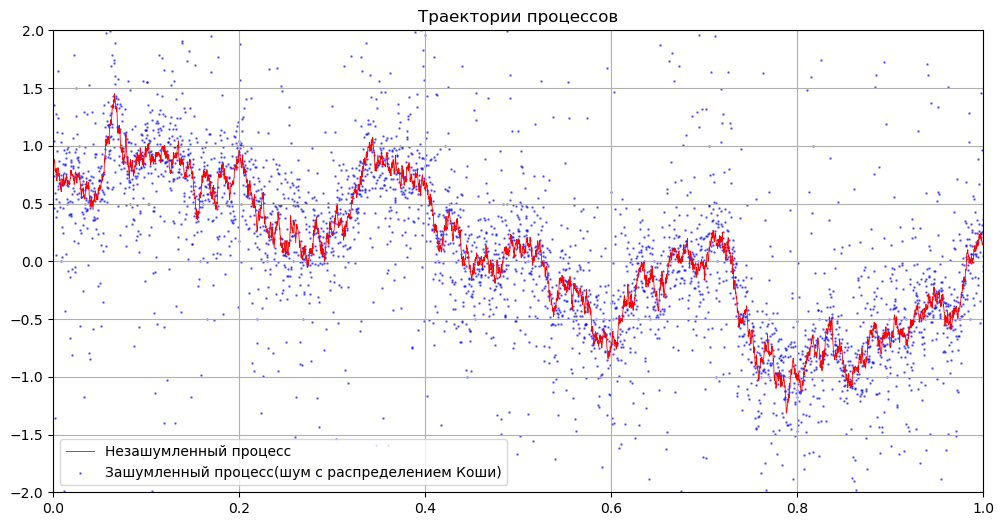

In [637]:
sigma = 1
L = 1
gamma = 0.2
n = 12
num_points = 2 ** n + 1
x = ornstein_uhlenbeck_simulation(sigma, n, L)
noise = cauchy_gen(0, gamma, num_points)
y = x + noise
grid = np.linspace(0, 1, num_points)
plt.figure(figsize=(12, 6))
plt.plot(grid, x, color='r', linewidth=0.6, label='Незашумленный процесс')
plt.scatter(grid, y, color='b', s=0.7, alpha=0.5, label='Зашумленный процесс(шум с распределением Коши)')
plt.xlim(0,1)
plt.ylim(-2,2)
plt.legend()
plt.grid()
plt.title('Траектории процессов')
plt.show()


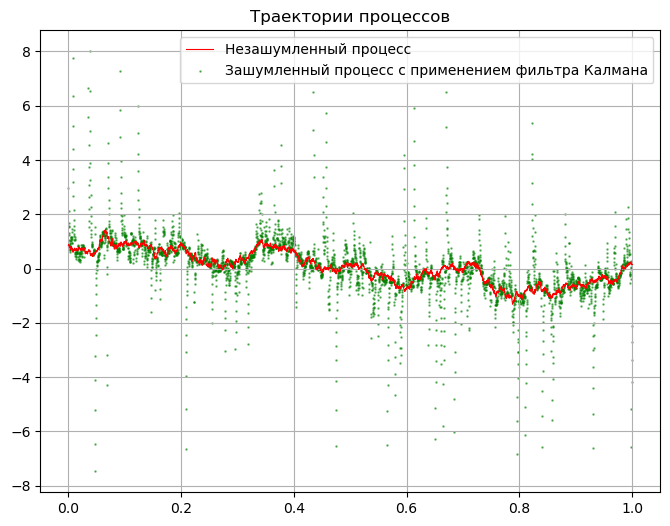

In [639]:
x_filtered, err = kalman_filter(sigma, L, r, y)
upper_limit = np.percentile(x_filtered, 99)
lower_limit = np.percentile(x_filtered, 1)
mask1 = x_filtered >= lower_limit
mask2 = x_filtered <= upper_limit
x_masked = x_filtered[mask1 & mask2]
grid_masked = grid[mask1 & mask2]
plt.figure(figsize=(8,6))
plt.plot(grid, x, color='red', linewidth=0.8, label='Незашумленный процесс')
plt.scatter(grid_masked, x_masked, color='green', s=0.7, alpha=0.5, label="Зашумленный процесс с применением фильтра Калмана")
plt.title("Траектории процессов")
plt.legend()
plt.grid()
plt.show()

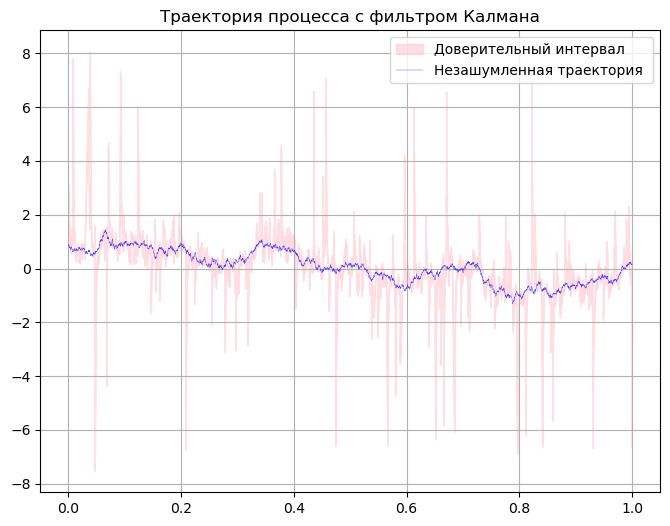

In [641]:
alpha = 0.1
eps = - np.sqrt(err) * norm.ppf(alpha / 2)
low = x_masked - eps[mask1 & mask2]
upper = x_masked + eps[mask1 & mask2]
plt.figure(figsize=(8,6))
plt.fill_between(grid_masked, low, upper, color="pink", alpha=0.5, label="Доверительный интервал")
plt.plot(grid, x, color='b', lw=0.3, alpha=0.7, label="Незашумленная траектория ")
plt.title("Траектория процесса с фильтром Калмана")
plt.legend()
plt.grid()
plt.show()

**Задание 11**

Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:

1. Система массового обслуживания.
   Первая координата поля — время поступления заявки в СМО (распределенное равномерно), а вторая — время обслуживания заявки (распределение $ \chi^2 $ с десятью степенями свободы).

2. Система массового обслуживания с циклической интенсивностью $ \lambda(1 + \cos(t)) $ и единичными скачками. 
   При помощи метода Льюиса и Шедлеара, свести задачу моделирования неоднородного пуассоновского процесса к моделированию двумерного пуассоновского поля, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

3. Работа страховой компании: 
   Первая координата — момент наступления страхового случая (равномерное распределение), вторая — величина ущерба (распределение Парето). Поступление капитала считать линейным по времени со скоростью $ c > 0 $, начальный капитал $ W > 0 $.


Part 1.

Рассматриваем первую координату поля на отрезке $[0, T]$. В теории пуассоновского поля $\lambda$ - интенсивность поля (в нашем случае интенсивность поступления заявок = среднее число новых заявок в единицу времени). Тогда случайная считающая мера, равная числу заявок определяется следующим образом:
$$n \sim Pois(\lambda T).$$
По условию время поступления заявки распределено расвномерно. Введём обозначение:
$$t_i \sim U[0, T], i=1,2,\dots,n.$$
После моделирования моментов поступления заявок необходимо упорядочить их по возрастанию. Пусть $\tau_i$ - время обслуживания заявки, по условию имеет распределение $\chi^2$ с 10 степенями свободы. Вспомним важное свойство этого распределения:
$$\mathbb{E}\tau_i = 10.$$
В момент времени $t_1$ в обработку поступает первая заявка, следовательно, в момент времени $t_1 + \tau_1$ она будет обработана. Причём во время обработки первой заявки могут поступать другие заявки, которые образуют очередь и обрабатываются постепенно. Тогда для последующих заявок выполняется правило: если $(i - 1)$-я заявка была обработана до момента поступления $i$-й заявки $t_i$, то она будет обработана в момент времени $t_i + \tau_i$, иначе она будет обработана через $\tau_i$ единиц после завершения обработки $(i - 1)$ заявки. Обозначим момент окончания обработки $(i - 1)$ заявки как $t_i^{end}$ Тогда можем посчитать количество заявок, находящихся в очереди в момент t:
$$Q(t) = \sum_{i=1}^{n} \mathbb{I}(t_i \leq t < t_{i - 1}^{end})$$
Ввиду свойств рассматриваемого пуассоновского поля:
$$t_{i+1} - t_{i} \sim Exp(\lambda).$$
Тогда решение задачи можем разбить на 3 случая. Среднее время обслуживания одной заявки равно числу степеней свободы, то есть 10. Среднее время между поступлением заявок равно $\frac{1}{\lambda}$. Тогда
1) Если $\frac{1}{\lambda} > 10$, то заявки поступают медленнее, чем обрабатываются, СМО справляется с задачей.
2) Если $\frac{1}{\lambda} < 10$, то СМО не справляется с обработкой.
3) Если $\frac{1}{\lambda} = 10$, СМО находится в "равновесии".

In [643]:
def QS_simulation(L, T, grid_size):
    n = np.random.poisson(L * T)
    t = np.random.uniform(0, T, n)
    t = np.sort(t)
    Q = np.zeros(grid_size)
    grid = np.linspace(0, T, grid_size)
    tau = np.random.chisquare(10, n)
    t_end = np.zeros(n)
    t_end[0] = t[0] + tau[0]
    for i in range(1, n):
        if t_end[i - 1] <= t[i]:
            t_end[i] = t[i] + tau[i]
        else:
            t_end[i] = t_end[i - 1] + tau[i]
    for i in range(grid_size):
        for j in range(1, n):
            if (grid[i] >= t[j]) and (grid[i] <= t_end[j - 1]):
                Q[i] += 1
    return grid, Q

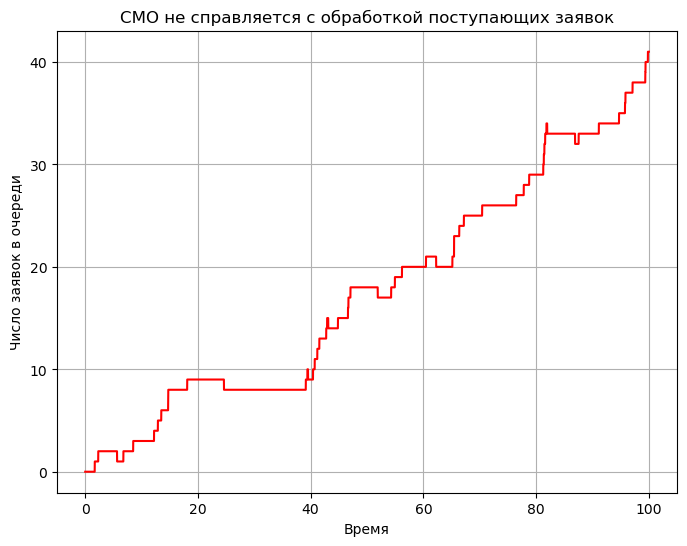

In [655]:
T = 100
L = 0.5
grid_size = 5000
grid, Q = QS_simulation(L, T, grid_size)
plt.figure(figsize=(8,6))
plt.plot(grid, Q, color='r',alpha=1)
plt.title("СМО не справляется с обработкой поступающих заявок")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Число заявок в очереди")
plt.show()

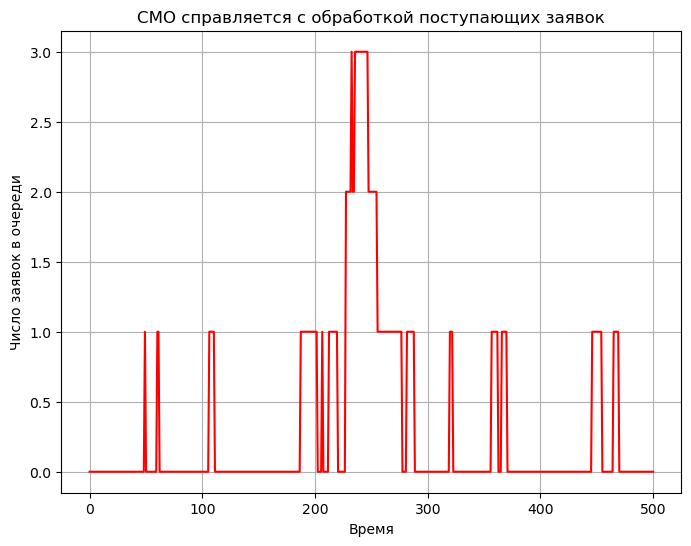

In [657]:
T = 500
L = 0.07
grid_size = 500
grid, Q = QS_simulation(L, T, grid_size)
plt.figure(figsize=(8,6))
plt.plot(grid, Q, color='r',alpha=1)
plt.title("СМО справляется с обработкой поступающих заявок")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Число заявок в очереди")
plt.show()

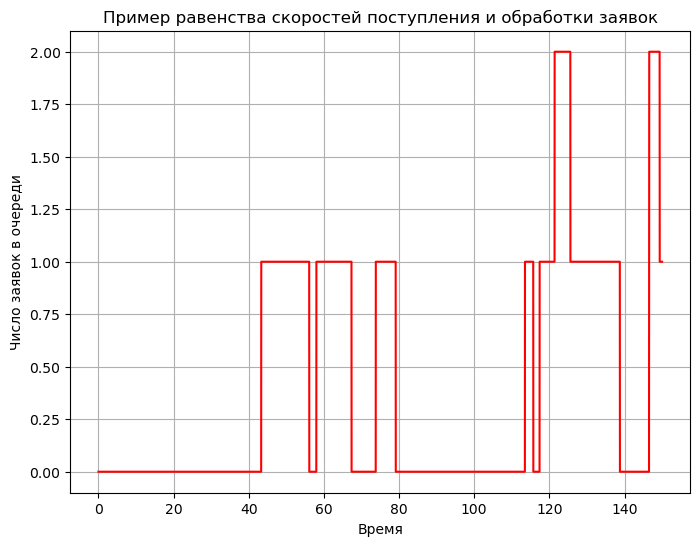

In [663]:
T = 150
L = 0.1
grid_size = 5000
grid, Q = QS_simulation(L, T, grid_size)
plt.figure(figsize=(8,6))
plt.plot(grid, Q, color='r',alpha=1)
plt.title("Пример равенства скоростей поступления и обработки заявок")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Число заявок в очереди")
plt.show()

Part 2.

Метод Льюиса и Шедлеара позволяет преобразовать неоднородный пауссоновский процесс в однородный. Для этого: 
1) Определим верхнюю границу для интенсивности. В нашем случае максимальная интенсивность равна $2\lambda$. 
2) Генерируем пуассоновский процесс как в предыдущем пункте с постоянной интенсивностью $2\lambda$.
3) Для каждого события, сгенерированного в однородном процессе, определяем, произошло ли оно на основе исходной функции интенсивности $\lambda(t)$. То есть удаляем $t_i$ с вероятностью $1 - \frac{\lambda(t_i)}{2\lambda}$.
Таким образом, как раз получим поле, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

In [665]:
def nonuniform_QS_simulation(L, T, grid_size):
    n = np.random.poisson(2 * L * T)
    t = np.random.uniform(0.0, T, n)
    t = np.sort(t)
    L_cycle = lambda t: (1 + np.cos(t)) / 2
    idx = np.random.uniform(0.0, 1.0, n) < L_cycle(t)
    t_new = t[idx]
    n_new = len(t_new)
    Q = np.zeros(grid_size)
    grid = np.linspace(0, T, grid_size)
    tau = np.random.chisquare(10, n_new)
    t_end = np.zeros(n_new)
    t_end[0] = t[0] + tau[0]
    for i in range(1, n_new):
        if t_end[i - 1] <= t_new[i]:
            t_end[i] = t_new[i] + tau[i]
        else:
            t_end[i] = t_end[i - 1] + tau[i]
    for i in range(grid_size):
        for j in range(1, n_new):
            if (grid[i] >= t_new[j]) and (grid[i] <= t_end[j - 1]):
                Q[i] += 1
    return grid, Q

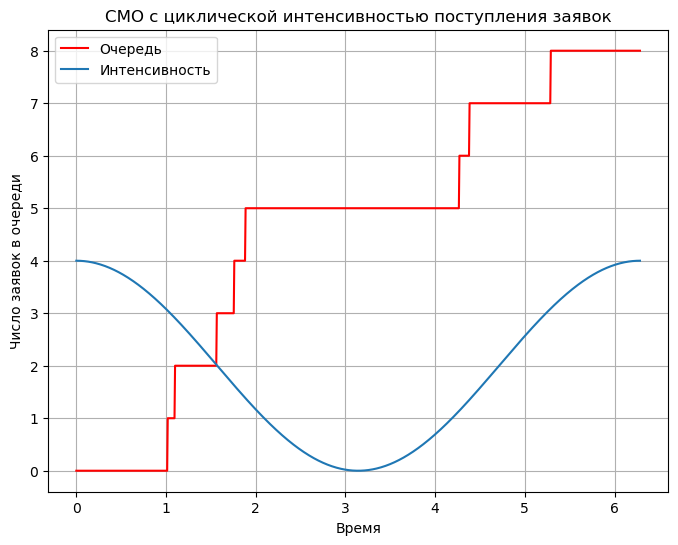

In [679]:
T = 2 * np.pi
L = 2
grid_size = 1000
grid, Q = nonuniform_QS_simulation(L, T, grid_size)
plt.figure(figsize=(8,6))
plt.plot(grid, Q, color='r',alpha=1, label='Очередь')
plt.plot(grid, L*(1+np.cos(grid)), label='Интенсивность')
plt.title("СМО с циклической интенсивностью поступления заявок")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Число заявок в очереди")
plt.legend()
plt.show()

Part 3.

Величина ущерба $\tau_i$ имеет распределение Парето с параметрами $(a, b)$. Знаем, что 
$$\mathbb{E}\tau_i = 
\begin{cases}
\frac{ab}{a - 1}, \quad a > 1, \\
+\infty, \quad a \leq 1.
\end{cases},$$
т.е. при $a \leq 1$ один страховой случай может привести к банкротству.
Будем моделировать случайную величину из этого распределения методом обратных функций:
$$F_X(x) = 1 - \left(\dfrac{b}{x}\right)^a \implies F^{-1}_X(x) = \dfrac{b}{(1-x)^{1/a}}.$$
Тогда
$$X = \frac{b}{(1 - Y)^{1 / a}}, \quad Y \sim U[0, 1].$$
$1-Y$ также является равномерно распределенной, значит
$$X = \frac{b}{Y^{1 / a}}, \quad Y \sim U[0, 1].$$
Капитал страховой компании изменяется по правилу:
$$W(t) = W_0 + ct - \sum_{i=1}^{Q(t)}\tau_i,$$
где $Q(t)$ - число страховых случаев. $\\$
После того, как в какой то момент времени $W(t) = 0$, оставшийся вектор заполняется нулями.
Алгоритм моделирования такой же как в случаях выше.

In [669]:
def insurance_simulating(L, T, grid_size, a, b, c, W_0):
    n = np.random.poisson(L * T)
    t = np.random.uniform(0.0, T, n)
    t = np.sort(t)
    tau = b / (np.random.uniform(0.0, 1.0, n)) ** (1 / a)
    grid = np.linspace(0, T, grid_size)
    Q = np.zeros(grid_size)
    for i in range(grid_size):
        for j in range(n):
            if grid[i] >= t[j]:
                Q[i] += tau[j]
    W = W_0 + c * grid - Q
    zero_idx = np.nonzero(W < 0)[0]
    if zero_idx.size > 0:
        W[zero_idx[0]:] = 0
    return grid, W

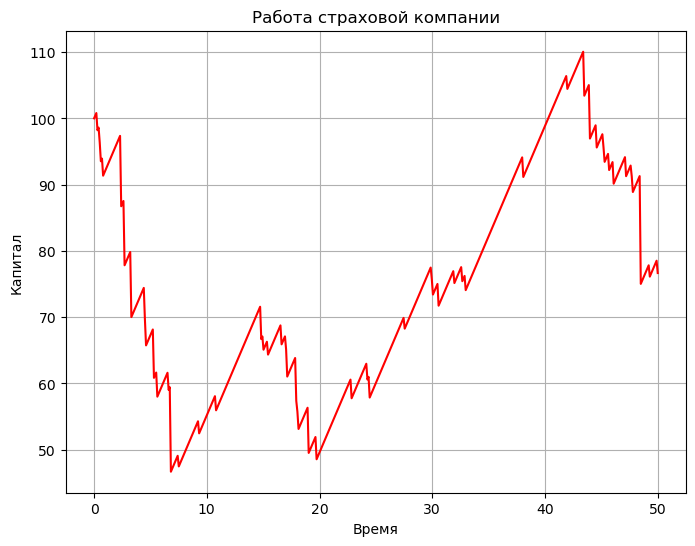

In [677]:
T = 50
L = 1
grid_size = 500
a = 2
b = 2
c = 4
W_0 = 100
grid, W = insurance_simulating(L, T, grid_size, a, b, c, W_0)
plt.figure(figsize=(8,6))
plt.plot(grid, W, color='r',alpha=1)
plt.title("Работа страховой компании")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Капитал")
plt.show()

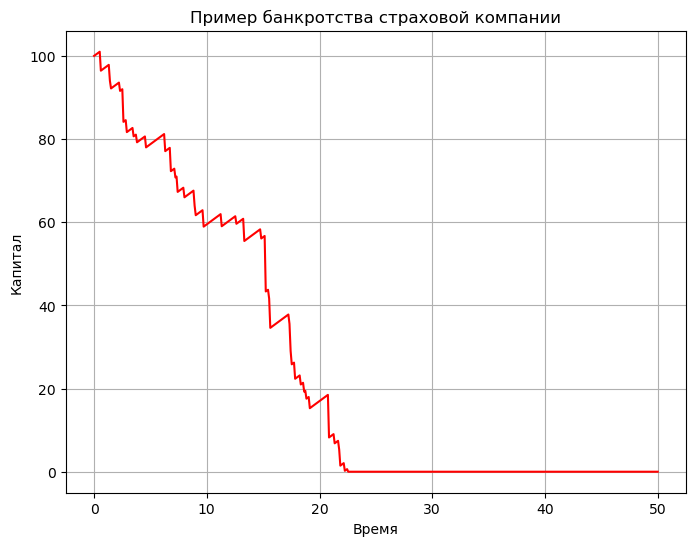

In [673]:
T = 50
L = 2
grid_size = 500
a = 2
b = 2
c = 2
W_0 = 100
grid, W = insurance_simulating(L, T, grid_size, a, b, c, W_0)
plt.figure(figsize=(8,6))
plt.plot(grid, W, color='r',alpha=1)
plt.title("Пример банкротства страховой компании")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Капитал")
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_11204\2683317341.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Пример банкротства при $a \leq 1$")


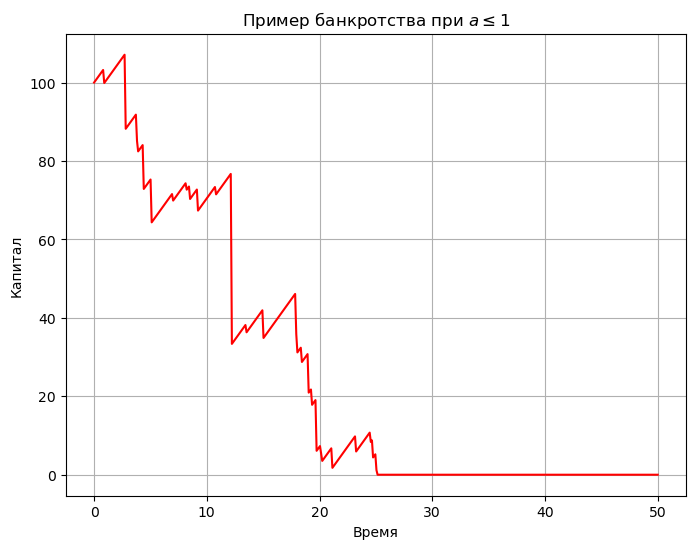

In [675]:
T = 50
L = 1
grid_size = 500
a = 0.9
b = 2
c = 4
W_0 = 100
grid, W = insurance_simulating(L, T, grid_size, a, b, c, W_0)
plt.figure(figsize=(8,6))
plt.plot(grid, W, color='r',alpha=1)
plt.title("Пример банкротства при $a \leq 1$")
plt.grid()
plt.xlabel("Время")
plt.ylabel("Капитал")
plt.show()